# <center>German real estate apartment listings over time</center>


## 0) Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)

<IPython.core.display.Javascript object>

## 1) Data Engineering

### 1.0) Helper functions:

In [2]:
def load_df(filepath):
    df = pd.read_csv(filepath, sep=";", low_memory=False)
    df.columns = [
        x.replace("obj_", "").replace("ga_", "").replace("geo_", "") for x in df.columns
    ]
    df = df.drop_duplicates(subset="scoutId")
    df = df[df.columns[~df.isnull().any()]]
    return df


def create_combined_df(date, rent_df, sale_df, group):
    rent_df["rent_m2"] = rent_df["baseRent"] / rent_df["livingSpace"]
    sale_df["price_m2"] = sale_df["purchasePrice"] / sale_df["livingSpace"]

    g = rent_df.groupby("zipCode")["rent_m2"].median()
    g.name = "rent_m2_zipCode"
    sale_df = sale_df.join(g, on="zipCode").copy()
    sale_df["yearly_ROI"] = sale_df["rent_m2_zipCode"] * 12 / sale_df["price_m2"]

    combined_df = pd.concat(
        [
            rent_df.groupby(group)["rent_m2"].median(),
            rent_df.groupby(group)["rent_m2"].size(),
            sale_df.groupby(group)["price_m2"].median(),
            sale_df.groupby(group)["price_m2"].size(),
            sale_df.groupby(group)["yearly_ROI"].median(),
        ],
        axis=1,
        keys=[
            "median_rent_m2 " + date,
            "num_rent " + date,
            "median_price_m2 " + date,
            "num_sale " + date,
            "median_yearly_ROI " + date,
        ],
    ).copy()
    return combined_df


def compute_change(df_column, startdate, enddate):
    return time_df[df_column + enddate] / time_df[df_column + startdate]

<IPython.core.display.Javascript object>

### 1.1) Data processing:

#### find dates:

In [3]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### create time series dataframe:

In [4]:
group = "zipCode"
time_df = pd.DataFrame()

for date in dates:
    rent_filepath = "../data/mieten" + date + ".csv"
    sale_filepath = "../data/kaufen" + date + ".csv"
    rent_df = load_df(rent_filepath)
    sale_df = load_df(sale_filepath)
    combined_df = create_combined_df(date, rent_df, sale_df, group)
    time_df = pd.concat([time_df, combined_df], axis=1)

time_df = time_df.replace([np.inf, -np.inf], np.nan)
time_df = time_df.dropna()

<IPython.core.display.Javascript object>

#### add columns for change:

In [5]:
startdate = dates[0]
enddate = dates[-1]

time_df["median_rent_m2 change"] = compute_change("median_rent_m2 ", startdate, enddate)
time_df["num_rent change"] = compute_change("num_rent ", startdate, enddate)
time_df["median_price_m2 change"] = compute_change(
    "median_price_m2 ", startdate, enddate
)
time_df["num_sale change"] = compute_change("num_sale ", startdate, enddate)
time_df["median_yearly_ROI change"] = compute_change(
    "median_yearly_ROI ", startdate, enddate
)

move_cols = [
    "median_rent_m2 change",
    "num_rent change",
    "median_price_m2 change",
    "num_sale change",
    "median_yearly_ROI change",
]
time_df = time_df[move_cols + [col for col in time_df.columns if col not in move_cols]]

<IPython.core.display.Javascript object>

## 2) Results

### 2.0) helper functions

In [11]:
def plot_1feature(group, attr, dates, feature1):
    x = dates
    y1 = [time_df.loc[attr][f"{feature1} {date}"] for date in x]
    color1 = "orange"

    fig, ax1 = plt.subplots()
    fig.suptitle(f"{feature1} on investment in {group} {attr}")

    ax1.set_xlabel("date")
    ax1.set_ylabel(feature1, color=color1)
    ax1.plot(x, y1, color=color1, label=feature1)
    ax1.set_xticklabels(x, rotation=90)

    ax1.legend()
    plt.show()


def plot_2features(rentsale_type, group, attr, dates, feature1, feature2):
    x = dates
    y1 = [time_df.loc[attr][f"{feature1} {date}"] for date in x]
    y2 = [time_df.loc[attr][f"{feature2} {date}"] for date in x]
    color1 = "blue"
    color2 = "green"

    fig, ax1 = plt.subplots()
    fig.suptitle(f"Apartments for {rentsale_type} in {group} {attr}")

    ax1.set_xlabel("date")
    ax1.set_ylabel(feature1, color=color1)
    ax1.plot(x, y1, color=color1, label=feature1)
    ax1.set_xticklabels(x, rotation=90)

    ax2 = ax1.twinx()
    ax2.set_ylabel(feature2, color=color2)
    ax2.plot(x, y2, linestyle="--", color=color2, label=feature2)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    plt.show()

<IPython.core.display.Javascript object>

### 2.1) Overview

In [7]:
min_num = 5
startdate = dates[0]
enddate = dates[-1]
time_ord = "median_yearly_ROI change"

time_filt = (
    (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
)

time_df[time_filt].sort_values(time_ord, ascending=False)

,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_ROI change,median_rent_m2 2020-04-04,num_rent 2020-04-04,median_price_m2 2020-04-04,num_sale 2020-04-04,median_yearly_ROI 2020-04-04,...,median_rent_m2 2020-04-16,num_rent 2020-04-16,median_price_m2 2020-04-16,num_sale 2020-04-16,median_yearly_ROI 2020-04-16,median_rent_m2 2020-04-19,num_rent 2020-04-19,median_price_m2 2020-04-19,num_sale 2020-04-19,median_yearly_ROI 2020-04-19
zipCode,,,,,,,,,,,,,,,,,,,,,
9120,0.97,1.04,0.44,0.58,2.20,5.23,162.0,3043.79,12.0,0.02,...,5.10,168.0,1348.31,7.0,0.05,5.10,169.0,1348.31,7.0,0.05
71263,1.75,0.67,0.82,0.67,2.11,10.16,6.0,3748.03,12.0,0.03,...,14.43,4.0,3120.00,9.0,0.06,17.75,4.0,3060.00,8.0,0.07
45472,1.11,1.11,0.55,1.67,1.99,7.50,19.0,3559.52,9.0,0.03,...,8.06,18.0,1884.99,14.0,0.05,8.29,21.0,1973.68,15.0,0.05
24937,1.00,1.05,0.51,1.36,1.97,8.50,65.0,2703.12,11.0,0.04,...,8.50,65.0,2703.12,11.0,0.04,8.50,68.0,1371.79,15.0,0.07
26382,0.98,1.06,0.51,1.00,1.92,5.83,35.0,3009.65,20.0,0.02,...,5.76,37.0,1540.54,19.0,0.04,5.69,37.0,1527.85,20.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47475,0.91,1.12,1.44,1.17,0.63,8.10,34.0,1175.94,6.0,0.08,...,8.42,39.0,1695.12,7.0,0.06,7.40,38.0,1695.12,7.0,0.05
50169,1.01,0.94,1.60,0.78,0.63,7.65,17.0,1893.62,9.0,0.05,...,7.36,14.0,2460.14,6.0,0.04,7.75,16.0,3026.67,7.0,0.03
72270,1.00,1.33,1.75,2.50,0.57,9.23,6.0,1530.98,14.0,0.07,...,9.23,6.0,1619.16,13.0,0.07,9.23,8.0,2684.56,35.0,0.04


<IPython.core.display.Javascript object>

### 2.2) Apartments for rent

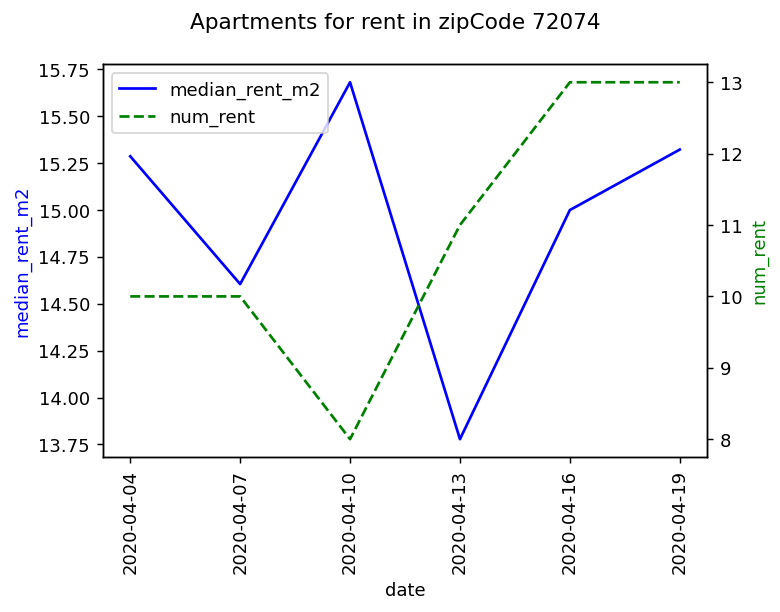

<IPython.core.display.Javascript object>

In [8]:
group_attributes = [72074]
feature1 = "median_rent_m2"
feature2 = "num_rent"

for attr in group_attributes:
    plot_2features("rent", group, attr, dates, feature1, feature2)

### 2.3) Apartments for sale

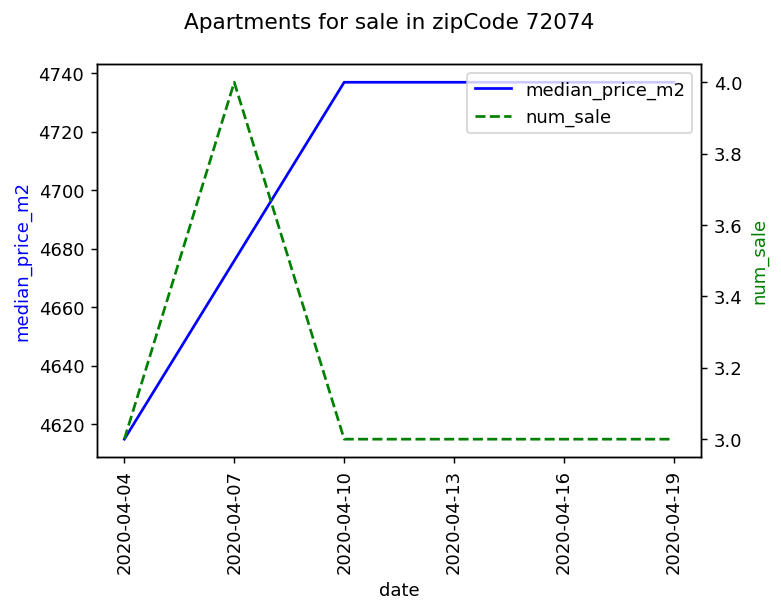

<IPython.core.display.Javascript object>

In [9]:
group_attributes = [72074]
feature1 = "median_price_m2"
feature2 = "num_sale"

for attr in group_attributes:
    plot_2features("sale", group, attr, dates, feature1, feature2)

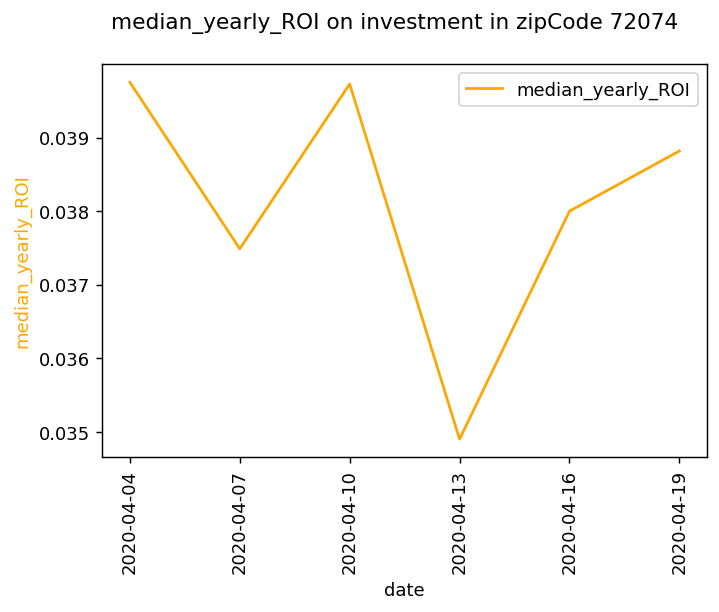

<IPython.core.display.Javascript object>

In [12]:
group_attributes = [72074]
feature1 = "median_yearly_ROI"

for attr in group_attributes:
    plot_1feature(group, attr, dates, feature1)